In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from imutils import paths

In [2]:
INIT_LR = 1e-4
EPOCHS = 15
BS = 32

In [3]:
DIRECTORY = "dataset"
CATEGORIES = ["both", "hat", "mask", "none"]

In [4]:
data = []
labels = []

In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
labels = preprocessing.label_binarize(labels, classes=CATEGORIES)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,
                         horizontal_flip=True,fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


C:\Users\panwa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/15
21/21 [==============================] - 51s 2s/step - loss: 0.6604 - accuracy: 0.2857 - val_loss: 0.4399 - val_accuracy: 0.7024
Epoch 2/15
21/21 [==============================] - 36s 2s/step - loss: 0.4501 - accuracy: 0.5848 - val_loss: 0.3146 - val_accuracy: 0.8750
Epoch 3/15
21/21 [==============================] - 37s 2s/step - loss: 0.3411 - accuracy: 0.7753 - val_loss: 0.2337 - val_accuracy: 0.9464
Epoch 4/15
21/21 [==============================] - 37s 2s/step - loss: 0.2660 - accuracy: 0.8810 - val_loss: 0.1827 - val_accuracy: 0.9643
Epoch 5/15
21/21 [==============================] - 36s 2s/step - loss: 0.2276 - accuracy: 0.8988 - val_loss: 0.1463 - val_accuracy: 0.9881
Epoch 6/15
21/21 [==============================] - 36s 2s/step - loss: 0.1903 - accuracy: 0.9375 - val_loss: 0.1182 - val_accuracy: 0.9881
Epoch 7/15
21/21 [==============================] - 38s 2s/step - loss: 0.1703 - accuracy: 0.9405 - val_loss: 0.1027 - val_accuracy: 0.9

In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
6/6 [==============================] - 8s 836ms/step


In [17]:
predIdxs = np.argmax(predIdxs, axis=1)

In [18]:
model.save("helmet_and_mask_detector.model", save_format="h5")

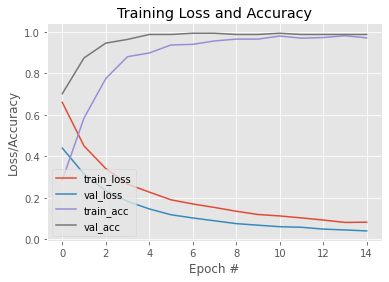

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")